# Project Outline

## 1. Load Data

In [2]:
import csv
import sqlite3
import pandas as pd


# Step 1: Load and parse the CSV file
file_path = 'adult-all.csv' #https://github.com/jbrownlee/Datasets/blob/master/adult-all.csv
data = []
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

with open(file_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        data.append(dict(zip(columns, row)))

# Step 2: Create a normalized database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create tables for categorical data
cursor.execute('''CREATE TABLE workclass (id INTEGER PRIMARY KEY, workclass TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE education (id INTEGER PRIMARY KEY, education TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE marital_status (id INTEGER PRIMARY KEY, marital_status TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE occupation (id INTEGER PRIMARY KEY, occupation TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE relationship (id INTEGER PRIMARY KEY, relationship TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE race (id INTEGER PRIMARY KEY, race TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE sex (id INTEGER PRIMARY KEY, sex TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE native_country (id INTEGER PRIMARY KEY, native_country TEXT UNIQUE)''')

# Create main table
cursor.execute('''CREATE TABLE adult_data 
               (id INTEGER PRIMARY KEY, 
               age INTEGER, 
               workclass_id INTEGER,
               fnlwgt INTEGER,
               education_id INTEGER,
               education_num INTEGER,
               marital_status_id INTEGER,
               occupation_id INTEGER,
               relationship_id INTEGER,
               race_id INTEGER,
               sex_id INTEGER,
               capital_gain INTEGER,
               capital_loss INTEGER,
               hours_per_week INTEGER,
               native_country_id INTEGER,
               income TEXT)''')

# Insert data into tables
for row in data:
    cursor.execute("INSERT OR IGNORE INTO workclass (workclass) VALUES (?)", (row['workclass'],))
    cursor.execute("INSERT OR IGNORE INTO education (education) VALUES (?)", (row['education'],))
    cursor.execute("INSERT OR IGNORE INTO marital_status (marital_status) VALUES (?)", (row['marital-status'],))
    cursor.execute("INSERT OR IGNORE INTO occupation (occupation) VALUES (?)", (row['occupation'],))
    cursor.execute("INSERT OR IGNORE INTO relationship (relationship) VALUES (?)", (row['relationship'],))
    cursor.execute("INSERT OR IGNORE INTO race (race) VALUES (?)", (row['race'],))
    cursor.execute("INSERT OR IGNORE INTO sex (sex) VALUES (?)", (row['sex'],))
    cursor.execute("INSERT OR IGNORE INTO native_country (native_country) VALUES (?)", (row['native-country'],))
    
    cursor.execute('''INSERT INTO adult_data 
                   (age, workclass_id, fnlwgt, education_id, education_num, marital_status_id,
                   occupation_id, relationship_id, race_id, sex_id, capital_gain, capital_loss,
                   hours_per_week, native_country_id, income)
                   VALUES 
                   (?, (SELECT id FROM workclass WHERE workclass = ?),
                   ?, (SELECT id FROM education WHERE education = ?),
                   ?, (SELECT id FROM marital_status WHERE marital_status = ?),
                   (SELECT id FROM occupation WHERE occupation = ?),
                   (SELECT id FROM relationship WHERE relationship = ?),
                   (SELECT id FROM race WHERE race = ?),
                   (SELECT id FROM sex WHERE sex = ?),
                   ?, ?, ?, (SELECT id FROM native_country WHERE native_country = ?), ?)''',
                   (row['age'], row['workclass'], row['fnlwgt'], row['education'], row['education-num'],
                    row['marital-status'], row['occupation'], row['relationship'], row['race'],
                    row['sex'], row['capital-gain'], row['capital-loss'], row['hours-per-week'],
                    row['native-country'], row['income']))

conn.commit()

# Step 3: Write an SQL query with joins to reconstruct the data
query = '''
SELECT ad.age, w.workclass, ad.fnlwgt, e.education, ad.education_num, 
       ms.marital_status, o.occupation, r.relationship, rc.race, s.sex, 
       ad.capital_gain, ad.capital_loss, ad.hours_per_week, nc.native_country, ad.income
FROM adult_data ad
JOIN workclass w ON ad.workclass_id = w.id
JOIN education e ON ad.education_id = e.id
JOIN marital_status ms ON ad.marital_status_id = ms.id
JOIN occupation o ON ad.occupation_id = o.id
JOIN relationship r ON ad.relationship_id = r.id
JOIN race rc ON ad.race_id = rc.id
JOIN sex s ON ad.sex_id = s.id
JOIN native_country nc ON ad.native_country_id = nc.id
'''

# Load the result into a Pandas DataFrame
data = pd.read_sql_query(query, conn)

# Display the first five of the DataFrame
print(data.head())

# Close the database connection
conn.close()

   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [3]:
print(data)

       age         workclass  fnlwgt  education  education_num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64                 ?  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital_status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
# Assign column names
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']
data.columns = columns

# Remove whitespace from string columns
string_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                  'relationship', 'race', 'sex', 'native-country', 'income']
for column in string_columns:
    data[column] = data[column].str.strip()

# Remove rows with missing data
data_cleaned = data.dropna()

# Replace '?' with 'unknown'
data_cleaned = data.replace('?', 'unknown')

# Standardize strings (convert to lowercase)
for column in string_columns:
    data_cleaned[column] = data_cleaned[column].str.lower()

# Correct column data types
data_cleaned['age'] = data_cleaned['age'].astype(int)
data_cleaned['fnlwgt'] = data_cleaned['fnlwgt'].astype(int)
data_cleaned['education-num'] = data_cleaned['education-num'].astype(int)
data_cleaned['capital-gain'] = data_cleaned['capital-gain'].astype(int)
data_cleaned['capital-loss'] = data_cleaned['capital-loss'].astype(int)
data_cleaned['hours-per-week'] = data_cleaned['hours-per-week'].astype(int)


In [10]:
# Identify categorical columns for one-hot encoding
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

# Perform one-hot encoding
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Label encode the 'income' column
le = LabelEncoder()
data_encoded['income'] = le.fit_transform(data_cleaned['income'])

In [12]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])


In [13]:
# Display the first few rows and info of the encoded dataset
print(data_encoded.head())
print(data_encoded.info())


        age    fnlwgt  education-num  capital-gain  capital-loss  \
0  0.025996 -1.061979       1.136512      0.146932     -0.217127   
1  0.828308 -1.007104       1.136512     -0.144804     -0.217127   
2 -0.046942  0.246034      -0.419335     -0.144804     -0.217127   
3  1.047121  0.426663      -1.197259     -0.144804     -0.217127   
4 -0.776316  1.408530       1.136512     -0.144804     -0.217127   

   hours-per-week  income  education_encoded  workclass_local-gov  \
0       -0.034087       0                  9                    0   
1       -2.213032       0                  9                    0   
2       -0.034087       0                 11                    0   
3       -0.034087       0                  1                    0   
4       -0.034087       0                  9                    0   

   workclass_never-worked  ...  native-country_puerto-rico  \
0                       0  ...                           0   
1                       0  ...                      

In [48]:
# Display the cleaned dataset info|
print(data_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                48842 non-null  int32 
 1   workclass          48842 non-null  object
 2   fnlwgt             48842 non-null  int32 
 3   education          48842 non-null  object
 4   education-num      48842 non-null  int32 
 5   marital-status     48842 non-null  object
 6   occupation         48842 non-null  object
 7   relationship       48842 non-null  object
 8   race               48842 non-null  object
 9   sex                48842 non-null  object
 10  capital-gain       48842 non-null  int32 
 11  capital-loss       48842 non-null  int32 
 12  hours-per-week     48842 non-null  int32 
 13  native-country     48842 non-null  object
 14  income             48842 non-null  object
 15  education_encoded  48842 non-null  int32 
 16  income_numeric     48842 non-null  int32

In [49]:
# Check the distribution of income values
print("Original income distribution:")
print(data_cleaned["income"].value_counts())

# Convert income to numerical values
data_cleaned['income_numeric'] = (data_cleaned['income'] == '>50K').astype(int)

# Verify the conversion
print("\nNumeric income distribution:")
print(data_cleaned['income_numeric'].value_counts())

# Display the mapping
print("\nMapping:")
print("0 -> <=50K")
print("1 -> >50K")

# Verify the mapping is correct
print("\nVerification:")
print(data_cleaned[['income', 'income_numeric']].drop_duplicates())


Original income distribution:
<=50k    37155
>50k     11687
Name: income, dtype: int64

Numeric income distribution:
0    48842
Name: income_numeric, dtype: int64

Mapping:
0 -> <=50K
1 -> >50K

Verification:
  income  income_numeric
0  <=50k               0
7   >50k               0


In [42]:
data_cleaned.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  education_encoded  income_numeric  
count    48842.000000       48842.000000         48842.0  
mean        40.422382          10.288420             0.0  
std         12.391444           3.874492             0.0  
min          1.000000           0.000000             0.0  
25%         40.000000           9.000000             0.0  
50%         40.000000          11.000000             0.0  
75%         45.000000          12.000000             0.0  
max         99.000000          15.000000             0.0

In [43]:
from sklearn.model_selection import train_test_split
# Check for any other potentially imbalanced categorical variables
for column in string_columns:
    if column != 'income':
        print(f"\n{column} distribution:")
        print(data_cleaned[column].value_counts(normalize=True).head())

# Perform train/test split with stratification on 'income'
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display the size of the train and test sets
print("\nTrain set size:", len(X_train))
print("Test set size:", len(X_test))

# Verify the stratification
print("\nIncome distribution in train set:")
print(y_train.value_counts(normalize=True))
print("\nIncome distribution in test set:")
print(y_test.value_counts(normalize=True))


workclass distribution:
private             0.694198
self-emp-not-inc    0.079071
local-gov           0.064207
unknown             0.057307
state-gov           0.040559
Name: workclass, dtype: float64

education distribution:
hs-grad         0.323164
some-college    0.222718
bachelors       0.164305
masters         0.054400
assoc-voc       0.042197
Name: education, dtype: float64

marital-status distribution:
married-civ-spouse    0.458192
never-married         0.329982
divorced              0.135805
separated             0.031325
widowed               0.031080
Name: marital-status, dtype: float64

occupation distribution:
prof-specialty     0.126367
craft-repair       0.125138
exec-managerial    0.124606
adm-clerical       0.114881
sales              0.112690
Name: occupation, dtype: float64

relationship distribution:
husband          0.403669
not-in-family    0.257627
own-child        0.155215
unmarried        0.104930
wife             0.047725
Name: relationship, dtype: float64

r

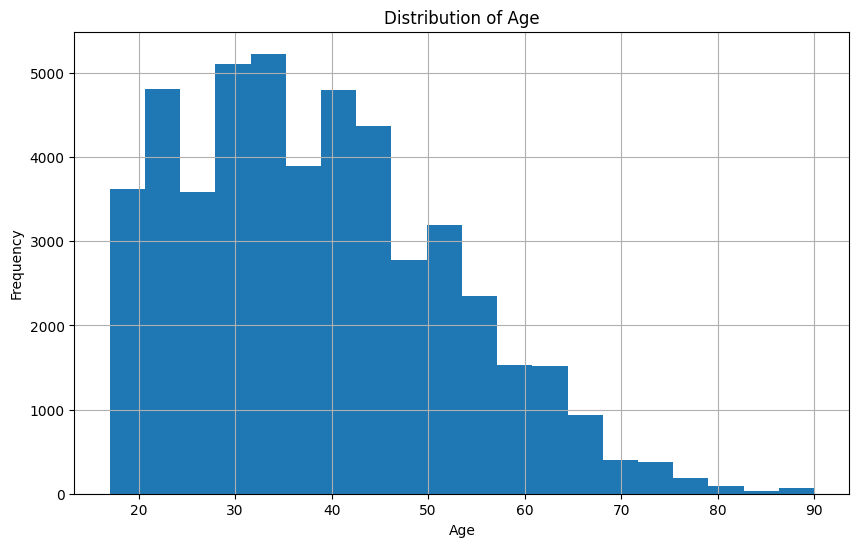

In [44]:
# Visualize the distribution of age
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
data_cleaned['age'].hist(bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

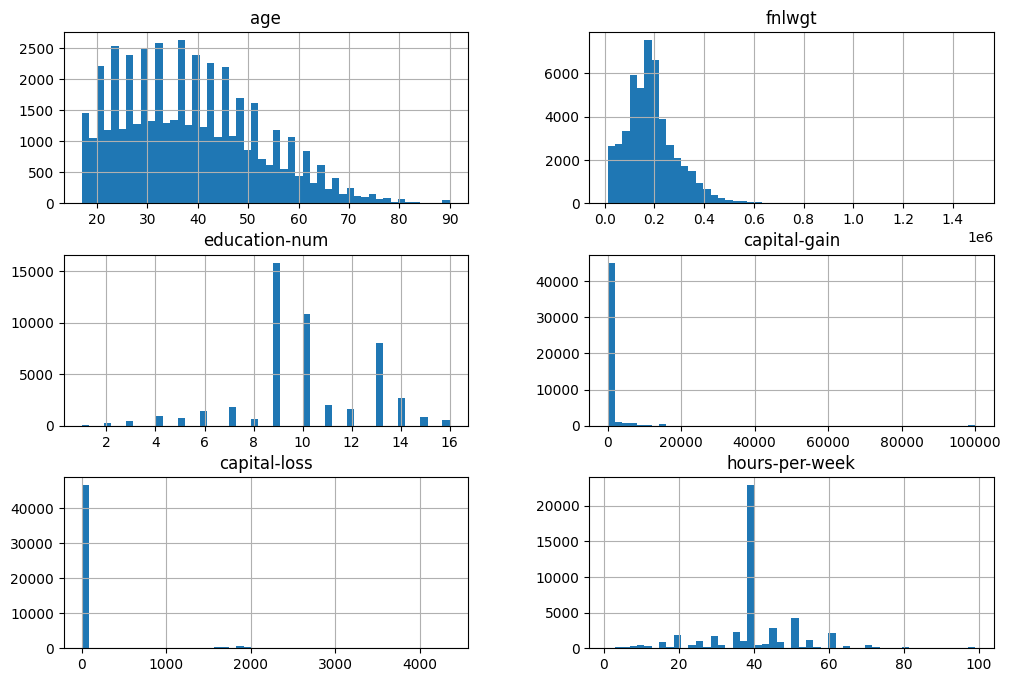

In [20]:
import matplotlib.pyplot as plt

# Generate histograms for all numeric columns
numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
data_cleaned[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.show()

In [45]:
from ydata_profiling import ProfileReport
import numpy as np


# Generate the report
profile = ProfileReport(data_cleaned, title="Profiling Report")

In [46]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


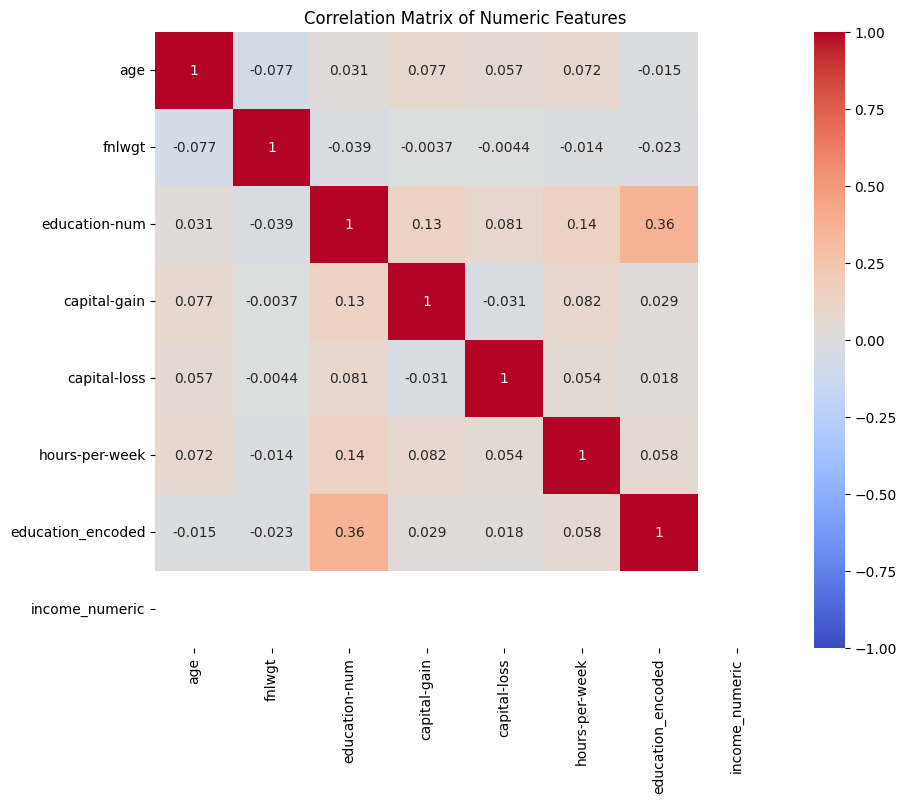

In [47]:
import seaborn as sns
# Visualize the correlation matrix
correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Stratify by the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify numeric & categorical features
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Log transform for 'capital-gain' and 'capital-loss'
def log_transform_capital(X):
    X = X.copy()
    for feature in ['capital-gain', 'capital-loss']:
        idx = numeric_features.index(feature)
        X[:, idx] = np.log1p(X[:, idx])
    return X

log_transformer = FunctionTransformer(log_transform_capital, validate=False)

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", log_transformer),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Logistic Regression pipeline
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("clf", LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_
mean_f1 = grid_search.best_score_
std_f1 = cv_results['std_test_score'][grid_search.best_index_]

# Evaluate on Training and Test sets
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Set up MLflow
MLFLOW_TRACKING_URI = "https://dagshub.com/kobekim27/EAS503.mlflow"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult_Income_Experiment")

# Log results to MLflow
with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "best_model", signature=signature)

print("\nExperiment completed and logged to MLflow.")
print("Best Params:", grid_search.best_params_)
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)


ImportError: cannot import name 'get_host' from 'urllib3.util.url' (C:\Users\pogoz\anaconda3\envs\py37\lib\site-packages\urllib3\util\url.py)

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Stratify by the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify numeric & categorical features
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Log transform for 'capital-gain' and 'capital-loss'
def log_transform_capital(X):
    X = X.copy()
    for feature in ['capital-gain', 'capital-loss']:
        idx = numeric_features.index(feature)
        X[:, idx] = np.log1p(X[:, idx])
    return X

log_transformer = FunctionTransformer(log_transform_capital, validate=False)

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", log_transformer),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Logistic Regression pipeline
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("clf", LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_
mean_f1 = grid_search.best_score_
std_f1 = cv_results['std_test_score'][grid_search.best_index_]

# Evaluate on Training and Test sets
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Set up MLflow
MLFLOW_TRACKING_URI = "https://dagshub.com/kobekim27/EAS503.mlflow"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult_Income_Experiment")

# Log results to MLflow
with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "best_model", signature=signature)

print("\nExperiment completed and logged to MLflow.")
print("Best Params:", grid_search.best_params_)
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)


ImportError: cannot import name 'get_host' from 'urllib3.util.url' (C:\Users\pogoz\anaconda3\envs\py37\lib\site-packages\urllib3\util\url.py)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import dagshub

# Initialize DagsHub
dagshub.init(repo_owner='kobekim27', repo_name='EAS503', mlflow=True)

# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Feature Engineering
def engineer_features(X):
    X = X.copy()
    
    # Combine education-num and hours-per-week
    X['education_work_intensity'] = X['education-num'] * X['hours-per-week']
    
    # Create age groups
    X['age_group'] = pd.cut(X['age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['0-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    # Combine capital-gain and capital-loss
    X['net_capital'] = X['capital-gain'] - X['capital-loss']
    
    # Create a feature for total work experience
    X['work_experience'] = X['age'] - X['education-num'] - 6
    X['work_experience'] = X['work_experience'].clip(lower=0)
    
    # Interaction between age and education-num
    X['age_education_interaction'] = X['age'] * X['education-num']
    
    return X

X = engineer_features(X)

# Update feature lists
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 
                    'education_work_intensity', 'net_capital', 'work_experience', 'age_education_interaction']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_group']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=1000),
    'RidgeClassifier': RidgeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Hyperparameter grids
param_grids = {
    'LogisticRegression': {'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2']},
    'RidgeClassifier': {'clf__alpha': [0.1, 1.0, 10.0]},
    'RandomForestClassifier': {'clf__n_estimators': [100, 200], 'clf__max_depth': [5, 10, None]},
    'XGBClassifier': {'clf__learning_rate': [0.01, 0.1], 'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 5, 7]}
}

# Set up MLflow
MLFLOW_TRACKING_URI = "https://dagshub.com/kobekim27/EAS503.mlflow"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult_Income_Experiment3")

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name}_FeatureEngineering"):
        pipeline = Pipeline([
            ("preprocessing", preprocessing),
            ("clf", clf)
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grids[clf_name], scoring='f1', cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        cv_results = grid_search.cv_results_
        mean_f1 = grid_search.best_score_
        std_f1 = cv_results['std_test_score'][grid_search.best_index_]

        # Evaluate on Training and Test sets
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')

        cm = confusion_matrix(y_test, y_pred_test)
        tn, fp, fn, tp = cm.ravel()

        # Log results to MLflow
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("cv_mean_f1", mean_f1)
        mlflow.log_metric("cv_std_f1", std_f1)
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)
        mlflow.log_metric("tp", tp)

        # Log the model
        signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
        mlflow.sklearn.log_model(best_model, "best_model", signature=signature)

        print(f"\nResults for {clf_name}:")
        print("Best Params:", grid_search.best_params_)
        print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
        print("Train F1:", f1_train)
        print("Test F1:", f1_test)
        print("Confusion Matrix:\n", cm)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn
import dagshub

# Initialize DagsHub
dagshub.init(repo_owner='kobekim27', repo_name='EAS503', mlflow=True)

# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Set up MLflow
MLFLOW_TRACKING_URI = "https://dagshub.com/kobekim27/EAS503.mlflow"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Adult_Income_Experiment4")

# Feature Selection Methods
def correlation_threshold(x, threshold=0.8):
    corr_matrix = x.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [col for col in x.columns if col not in to_drop]


def feature_importance(X, y, threshold=0.01):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    return X[importances[importances > threshold].index]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Feature Selection Pipelines
pipelines = {
    'Correlation_Threshold': Pipeline([
        ('preprocessor', preprocessor),
        ('correlation', FunctionTransformer(correlation_threshold, kw_args={'threshold': 0.8})),
        ('selector', FunctionTransformer(lambda X, columns: X[columns])),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'Feature_Importance': Pipeline([
        ('preprocessor', preprocessor),
        ('importance', FunctionTransformer(feature_importance, kw_args={'threshold': 0.01})),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'Variance_Threshold': Pipeline([
        ('preprocessor', preprocessor),
        ('variance', VarianceThreshold(threshold=0.1)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

# Train and evaluate each pipeline
for name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=f"{name}_FeatureSelection"):
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Get selected features
        if name == 'Correlation_Threshold':
            selected_features = pipeline.named_steps['correlation'].get_feature_names_out()
        elif name == 'Feature_Importance':
            selected_features = pipeline.named_steps['importance'].get_feature_names_out()
        else:  # Variance_Threshold
            selected_features = pipeline.named_steps['variance'].get_feature_names_out()
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate F1 scores
        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        
        # Log results to MLflow
        mlflow.log_param("num_selected_features", len(selected_features))
        mlflow.log_param("selected_features", ", ".join(selected_features))
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)
        
        # Log the model
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"Feature Selection Method: {name}")
        print(f"Number of selected features: {len(selected_features)}")
        print(f"F1 Score (Train): {f1_train:.4f}")
        print(f"F1 Score (Test): {f1_test:.4f}")
        print("Selected features:", ", ".join(selected_features))
        print("\n")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import LabelEncoder
# Initialize DagsHub
dagshub.init(repo_owner='kobekim27', repo_name='EAS503', mlflow=True)
# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Create scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.savefig('scree_plot.png')
plt.close()

# Select number of components based on cumulative explained variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Apply PCA with selected number of components
pca_final = PCA(n_components=n_components)
X_train_pca_final = pca_final.fit_transform(X_train_scaled)
X_test_pca_final = pca_final.transform(X_test_scaled)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_pca_final, y_train)

# Make predictions
y_pred_train = rf_classifier.predict(X_train_pca_final)
y_pred_test = rf_classifier.predict(X_test_pca_final)

# Calculate F1 scores
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Log results with MLflow
with mlflow.start_run(run_name="Experiment_5_PCA"):
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_artifact("scree_plot.png")
    mlflow.sklearn.log_model(rf_classifier, "model")
    
    print(f"Number of selected components: {n_components}")
    print(f"F1 Score (Train): {f1_train:.4f}")
    print(f"F1 Score (Test): {f1_test:.4f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Assuming 'data_cleaned' is your final DataFrame and 'income' is the target
X = data_cleaned.drop('income', axis=1)
y = data_cleaned['income']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)


# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train initial Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

with mlflow.start_run(run_name="Experiment_6_Feature_Importance"):
    # Log feature importances
    for feature, importance in feature_importances.items():
        mlflow.log_metric(f"importance_{feature}", importance)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    mlflow.log_artifact('feature_importances.png')
    plt.close()

    # Train models with different numbers of top features
    top_feature_counts = [5, 10, 15, 20, len(X.columns)]
    for n_features in top_feature_counts:
        top_features = feature_importances.index[:n_features]
        X_train_top = X_train_scaled[:, X.columns.get_indexer(top_features)]
        X_test_top = X_test_scaled[:, X.columns.get_indexer(top_features)]

        rf_top = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_top.fit(X_train_top, y_train)

        y_pred_train = rf_top.predict(X_train_top)
        y_pred_test = rf_top.predict(X_test_top)

        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')

        mlflow.log_param(f"n_top_features", n_features)
        mlflow.log_metric(f"f1_train_{n_features}", f1_train)
        mlflow.log_metric(f"f1_test_{n_features}", f1_test)

        print(f"Top {n_features} features:")
        print(f"F1 Score (Train): {f1_train:.4f}")
        print(f"F1 Score (Test): {f1_test:.4f}")
        print()

    # Log the best model
    best_model = RandomForestClassifier(n_estimators=100, random_state=42)
    best_model.fit(X_train_scaled, y_train)
    mlflow.sklearn.log_model(best_model, "best_model")

print("Experiment 6 completed and logged to MLflow")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Assuming X and y are already defined as in your original code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Simplified grouping logic for education levels
def education_group(edu_num):
    if edu_num <= 10:
        return 'Low'
    elif edu_num <= 13:
        return 'Medium'
    else:
        return 'High'

X_train['edu_group'] = X_train['education-num'].apply(education_group)
X_test['edu_group'] = X_test['education-num'].apply(education_group)

# Simplified grouping logic for working hours
def hour_group(hours):
    if hours < 40:
        return 'Part-time'
    elif hours <= 45:
        return 'Full-time'
    else:
        return 'Overtime'

X_train['hour_group'] = X_train['hours-per-week'].apply(hour_group)
X_test['hour_group'] = X_test['hours-per-week'].apply(hour_group)

# Encode categorical variables
le = LabelEncoder()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
for feature in categorical_features:
    X_train[feature] = le.fit_transform(X_train[feature].astype(str))
    X_test[feature] = le.transform(X_test[feature].astype(str))

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(['edu_group', 'hour_group'], axis=1))
X_test_scaled = scaler.transform(X_test.drop(['edu_group', 'hour_group'], axis=1))

with mlflow.start_run(run_name="Experiment_7_Education_Hours_Analysis"):
    # Train models for each education and hour group combination
    edu_groups = ['Low', 'Medium', 'High']
    hour_groups = ['Part-time', 'Full-time', 'Overtime']
    
    min_samples_threshold = 10  # Minimum number of samples required per group
    
    valid_f1_scores = []
    valid_groups = []
    
    for edu in edu_groups:
        for hour in hour_groups:
            train_mask = (X_train['edu_group'] == edu) & (X_train['hour_group'] == hour)
            test_mask = (X_test['edu_group'] == edu) & (X_test['hour_group'] == hour)
            
            X_train_group = X_train_scaled[train_mask]
            y_train_group = y_train[train_mask]
            X_test_group = X_test_scaled[test_mask]
            y_test_group = y_test[test_mask]
            
            # Check if the group has enough samples
            if len(X_train_group) >= min_samples_threshold and len(X_test_group) >= min_samples_threshold:
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                rf.fit(X_train_group, y_train_group)
                
                y_pred_test = rf.predict(X_test_group)
                
                f1 = f1_score(y_test_group, y_pred_test, average='weighted')
                
                group_name = f"{edu}_{hour}"
                mlflow.log_metric(f"f1_score_{group_name}", f1)
                
                valid_f1_scores.append(f1)
                valid_groups.append(group_name)
                
                print(f"Education: {edu}, Hours: {hour}")
                print(f"F1 Score: {f1:.4f}")
                print(f"Samples: Train - {len(X_train_group)}, Test - {len(X_test_group)}")
                print()
            else:
                # Log skipped groups due to insufficient samples
                group_name = f"{edu}_{hour}"
                mlflow.log_param(f"skipped_{group_name}", True)
                print(f"Skipping Education: {edu}, Hours: {hour} due to insufficient samples")
    
    # Plot F1 scores for valid groups only
    plt.figure(figsize=(12, 6))
    plt.bar(valid_groups, valid_f1_scores)
    plt.title('F1 Scores by Education Level and Working Hours')
    plt.xlabel('Education Level - Working Hours')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('edu_hours_f1_scores.png')
    mlflow.log_artifact('edu_hours_f1_scores.png')
    plt.close()

    # Log the overall model trained on all data
    overall_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    overall_rf.fit(X_train_scaled, y_train)
    mlflow.sklearn.log_model(overall_rf, "overall_model")

print("Experiment 7 completed and logged to MLflow")


In [ ]:
import joblib
from sklearn.ensemble import VotingClassifier

# Assuming 'best_model' is your trained model
best_model = VotingClassifier(estimators=[])  # Replace with your actual model
joblib.dump(best_model, 'final_model.joblib')